In [48]:
#import dependencies
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy import stats
from scipy.stats import linregress
import gmaps
import os
import json
import pprint as pprint

In [49]:
# Organize population inflows and outflows data
inflow_df = pd.read_csv('input_data/countyinflow1718.csv')
outflow_df = pd.read_csv('input_data/countyoutflow1718.csv')

#pull out pertinant rows in each df
inflow_df = inflow_df[inflow_df['y1_countyname'].str.contains('County Non-migrants') | inflow_df['y1_countyname'].str.contains('County Total Migration-US and Foreign')]
outflow_df = outflow_df[outflow_df['y2_countyname'].str.contains('County Non-migrants') | outflow_df['y2_countyname'].str.contains('County Total Migration-US and Foreign')]

#rename columns
inflow_df = inflow_df.rename(columns = {"y1_countyname":"inflow_county","y1_state":"inflow_state","n1":"inflow_n1","n2":"inflow_n2","agi_y":"inflow_agi"})
outflow_df = outflow_df.rename(columns = {"y2_countyname":"outflow_county","y2_state":"outflow_state","n1":"outflow_n1","n2":"outflow_n2","agi_x":"outflow_agi"})

#merge df
county_in_out_df = pd.merge(outflow_df,inflow_df,left_on=["outflow_state","outflow_county"],right_on=["inflow_state","inflow_county"])

#remove unneccessary columns
county_in_out_df = county_in_out_df.drop(columns=['y1_statefips_x', 'y1_countyfips_x', 'y2_statefips_x', 'y2_countyfips_x', 'y2_statefips_y', 'y2_countyfips_y', 'y1_statefips_y', 'y1_countyfips_y'])

In [50]:
#separate data based on description and merge
non_migrants = county_in_out_df[county_in_out_df['outflow_county'].str.contains("Non-migrants")]
non_migrants = non_migrants.reset_index()

us_foreign = county_in_out_df[county_in_out_df['outflow_county'].str.contains('US and Foreign')]
us_foreign = us_foreign.reset_index()

# Merge two Dataframes on index of both the dataframes
final = non_migrants.merge(us_foreign, left_index=True, right_index=True)

#drop unnecessary columns
final = final.drop(columns=['index_x', 'outflow_state_x', 'outflow_county_x', 'outflow_n1_x', 'outflow_n2_x', 'agi_x_x', 'index_y',
                   'outflow_state_y', 'outflow_county_y', 'inflow_state_y', 'inflow_county_y', 'inflow_n2_x', 'outflow_n2_y', 'inflow_n2_y'])
final

,inflow_state_x,inflow_county_x,inflow_n1_x,agi_y_x,outflow_n1_y,agi_x_y,inflow_n1_y,agi_y_y
0,AL,Autauga County Non-migrants,18028,1143227,1888,99955,1925,100564
1,AL,Baldwin County Non-migrants,73765,5421048,4609,238893,6818,491043
2,AL,Barbour County Non-migrants,7176,322664,445,16473,389,15215
3,AL,Bibb County Non-migrants,6054,332129,450,18686,376,15189
4,AL,Blount County Non-migrants,17300,982763,1148,51327,1211,52661
...,...,...,...,...,...,...,...,...
3001,WY,Sweetwater County Non-migrants,15417,1216231,1084,71652,834,43730
3002,WY,Teton County Non-migrants,10727,3408826,1218,109912,1188,212532
3003,WY,Uinta County Non-migrants,7077,509964,485,31788,441,22104
3004,WY,Washakie County Non-migrants,2875,193724,180,7868,162,8388


In [51]:
#strip words from description
final['inflow_county_x'] = final['inflow_county_x'].str.rstrip(' Non-migrants')

#rename columns
final = final.rename(columns={'inflow_state_x': 'State', 'inflow_county_x': 'County', 'inflow_n1_x': 'Returns Total', 
                             'agi_y_x': 'Total AGI', 'outflow_n1_y': 'Outflow', 'agi_x_y': 'Outflow AGI',
                             'inflow_n1_y': 'Inflow', 'agi_y_y': 'Inflow AGI'})

In [52]:
#add net flow column and compute values
final['Net Inflow(Outflow)'] = (final['Inflow'] - final['Outflow']).astype(int)

#add percentage column and compute values
final['Flow(%)'] = (final['Net Inflow(Outflow)'] / final['Returns Total']).astype(float)

#format percentage column
final['Flow(%)'] = (final['Flow(%)'] * 100).round(3)

#sort by percentage column values
final = final.sort_values(by=['Flow(%)'], ascending=False)


In [53]:
#read in unemployment data
unemployment = pd.read_csv('input_data/unemployment.csv')

#drop unnecessary columns
unemployment = unemployment.drop(columns=['Year', 'Force', 'Employed', 'Unemployed'])
#rename columns
unemployment = unemployment.rename(columns={'(%)': 'Unemployment Rate(%)'})
#reorder columns
unemployment = unemployment[['State', 'County', 'Unemployment Rate(%)']]

In [54]:
final = final.merge(unemployment, on=['State', 'County'])
final

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%)
0,NV,Eureka County,556,38167,26,2961,78,4974,52,9.353,2.7
1,NE,Hooker County,279,10670,-1,-1,21,874,22,7.885,3.7
2,ND,McKenzie County,3461,464151,575,46125,837,52025,262,7.570,1.7
3,CO,Mineral County,324,21265,-1,-1,22,1256,23,7.099,2.6
4,ND,Williams County,12437,1217462,1644,112302,2504,137024,860,6.915,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,TX,Roberts County,275,17228,29,2415,-1,-1,-30,-10.909,3.0
2996,MT,Treasure County,274,14096,31,1657,-1,-1,-32,-11.679,3.0
2997,NE,Logan County,253,11987,29,1271,-1,-1,-30,-11.858,2.8
2998,TX,Kent County,252,16917,30,1474,-1,-1,-31,-12.302,2.4


In [55]:
#Rent data

#read in rent data
rent_data = pd.read_csv('input_data/FY2018_50_County_rev.csv')

#delete unnecessary columns
rent_data = rent_data.drop(columns = ['fips2010', 'state', 'cbsasub18', 'areaname18', 'county', 'cousub', 'name', 'pop2010', 'hu2010', 'rent50_0', 'rent50_3', 'rent50_4'])

#rename columns
rent_data = rent_data.rename(columns = {"rent50_1":"1 Bed Average","rent50_2":"2 Bed Average","cntyname":"County","state_alpha":"State"})

#reorder data
rent_data = rent_data[['State', 'County', '1 Bed Average', '2 Bed Average']]
rent_data

,State,County,1 Bed Average,2 Bed Average
0,AL,Autauga County,742,890
1,AL,Baldwin County,809,929
2,AL,Barbour County,531,706
3,AL,Bibb County,832,955
4,AL,Blount County,832,955
...,...,...,...,...
4765,PR,Yabucoa Municipio,478,577
4766,PR,Yauco Municipio,340,390
4767,VI,St. Croix,833,1017
4768,VI,St. John,1284,1596


In [56]:
#merge rent data to final
final = final.merge(rent_data, on=['State', 'County'])

In [57]:
#read in tax data
state_tax_data = pd.read_excel('input_data/state_income_tax.xlsx')

#rename columns
#state_tax_data = state_tax_data.rename(columns = {"County Name":"County", "Median Home Price Q2 2017":"Median Home Price 2017"})

# merge data
final = final.merge(state_tax_data, on=['State'])
final

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%),1 Bed Average,2 Bed Average,Highest Marginal Income Tax Rate (%)
0,NV,Eureka County,556,38167,26,2961,78,4974,52,9.353,2.7,709,943,0.00
1,NV,Nye County,14356,776985,1233,58992,2032,112840,799,5.566,5.7,709,869,0.00
2,NV,Storey County,1489,103314,161,7260,240,20234,79,5.306,4.4,811,1047,0.00
3,NV,Esmeralda County,283,14434,26,956,40,1816,14,4.947,4.8,575,697,0.00
4,NV,Lyon County,19652,1035138,2048,101840,2926,146612,878,4.468,5.4,702,934,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4536,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1087,1369,6.99
4537,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1087,1369,6.99
4538,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1731,2189,6.99
4539,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1731,2189,6.99


In [58]:
#Home Price data

#read in homeprice data
home_price_data = pd.read_csv('input_data/Median_Home_Price_csvfinal.csv')

#rename columns
home_price_data = home_price_data.rename(columns = {"County Name":"County"})

home_price_data.head()

,State,County,Median Home Price 2017
0,AL,Autauga County,142792
1,AL,Baldwin County,210870
2,AL,Barbour County,94248
3,AL,Bibb County,112903
4,AL,Blount County,130775


In [59]:
home_price_data.dtypes

State                     object
County                    object
Median Home Price 2017     int64
dtype: object

In [60]:
#merge home price data to final
final = final.merge(home_price_data, on=['State', 'County'])
final

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%),1 Bed Average,2 Bed Average,Highest Marginal Income Tax Rate (%),Median Home Price 2017
0,NV,Eureka County,556,38167,26,2961,78,4974,52,9.353,2.7,709,943,0.00,94477
1,NV,Nye County,14356,776985,1233,58992,2032,112840,799,5.566,5.7,709,869,0.00,142227
2,NV,Storey County,1489,103314,161,7260,240,20234,79,5.306,4.4,811,1047,0.00,214644
3,NV,Esmeralda County,283,14434,26,956,40,1816,14,4.947,4.8,575,697,0.00,83563
4,NV,Lyon County,19652,1035138,2048,101840,2926,146612,878,4.468,5.4,702,934,0.00,179631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1087,1369,6.99,435477
4446,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1087,1369,6.99,435477
4447,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1731,2189,6.99,435477
4448,CT,Fairfield County,357116,69375082,21235,3017316,17929,2869252,-3306,-0.926,4.0,1731,2189,6.99,435477


In [61]:
final.to_csv('output_data/final.csv', index=False)

In [62]:
#create a random sample of 10%
sample_300 = final.sample(n=300)
sample_300

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%),1 Bed Average,2 Bed Average,Highest Marginal Income Tax Rate (%),Median Home Price 2017
1807,VT,Essex County,2279,101084,177,5280,186,7537,9,0.395,3.6,645,823,8.75,134687
446,TX,Travis County,431303,49131355,47553,3238771,48623,3884317,1070,0.248,2.8,1104,1350,0.00,347488
603,FL,Suwannee County,12641,580805,1041,34681,1244,46573,203,1.606,3.7,597,686,0.00,100040
3650,NH,Rockingham County,129670,13621666,9769,837564,10379,882097,610,0.470,2.8,1005,1269,0.00,352626
2899,MS,Harrison County,65100,3559547,7495,300382,7574,323114,79,0.121,4.5,705,815,5.00,165728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,ME,Waldo County,14846,814885,1039,46800,1104,56847,65,0.438,3.5,724,831,7.15,165353
662,MT,Yellowstone County,61209,4466111,3464,187045,3662,192899,198,0.323,3.3,757,1001,6.90,230936
3430,ME,Aroostook County,24387,1229880,951,47595,861,42588,-90,-0.369,4.8,616,713,7.15,104510
3253,ME,Waldo County,14846,814885,1039,46800,1104,56847,65,0.438,3.5,724,831,7.15,165353


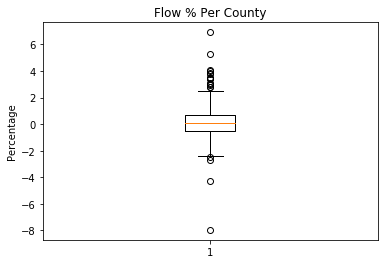

In [63]:
#runbow/whisker plot on sample data
fig1, ax1 = plt.subplots()
ax1.set_title('Flow % Per County')
ax1.set_ylabel('Percentage')
ax1.boxplot(sample_300['Flow(%)'])
plt.show()

In [64]:
quartiles = sample_300['Flow(%)'].quantile([.25, .5, .75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq - lowerq

print(f'The lower quartiles is: {lowerq}')
print(f'The upper quartiles is: {upperq}')
print(f'The interquartile range is: {iqr}')
print(f'The median is: {quartiles[0.5]}')

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f'Values below {lower_bound} may be outliers.')
print(f'Values above {upper_bound} may be outliers.')

The lower quartiles is: -0.53525
The upper quartiles is: 0.719
The interquartile range is: 1.2542499999999999
The median is: 0.079
Values below -2.416625 may be outliers.
Values above 2.6003749999999997 may be outliers.


In [65]:
sample_300.to_csv('output_data/sample_300.csv', index=False)